In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta
import re
import matplotlib.pyplot as plt

In [2]:
def clean_tweet(tweet):
        # method for cleaning tweets used in clean_twitter_data dag

        tweet = re.sub(r'http\S+', '', tweet)
        # Remove mentions
        tweet = re.sub(r'@[A-Za-z0-9_]+', '', tweet)
        # Remove hashtags
        tweet = re.sub(r'#', '', tweet)
        # Remove non-alphabetic characters
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)
        # Convert to lowercase
        tweet = tweet.lower()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        words = tweet.split()
        filtered_words = [word for word in words if word not in stop_words]
        return ' '.join(filtered_words)
    
def splitScore(df):
    df['negative'] = df['score'].apply(lambda x: x.get('neg'))
    df['neutral'] = df['score'].apply(lambda x: x.get('neu'))
    df['positive'] = df['score'].apply(lambda x: x.get('pos'))
    df['compound'] = df['score'].apply(lambda x: x.get('compound'))
    return df

In [3]:
tt2019 = pd.read_csv('twitter_2019.csv')
tt2020 = pd.read_csv('twitter_2020.csv')
tt2021 = pd.read_csv('twitter_2021.csv')
tt2022 = pd.read_csv('twitter_2022.csv')

In [4]:
fullDf = pd.concat([tt2019, tt2020, tt2021, tt2022])
fullDf

,Datetime,Text,Username,likeCount,Date
0,2019-01-01 19:25:18+00:00,2. AirPods will continue their dominance as th...,jmj,490,2019-01-01
1,2019-01-01 22:03:44+00:00,New way of living for 2019.\n\nBuy things I wa...,ACXtrades,112,2019-01-01
2,2019-01-01 01:35:46+00:00,Have a happy new year people may the $SPY $QQQ...,Sandro_power,68,2019-01-01
3,2019-01-01 13:19:28+00:00,$AAPL monthly testing support and moving on ex...,johnscharts,28,2019-01-01
4,2019-01-01 19:58:07+00:00,$SPX 2018 contributors: total return was -4.38...,hsilverb,12,2019-01-01
...,...,...,...,...,...
36495,2022-12-31 21:10:44+00:00,#music $aapl #inspirational #guitar #jazz #mod...,stonksrus,0,2022-12-31
36496,2022-12-31 21:08:20+00:00,Don't miss the next move in few hours: $AAPL $...,atkinsoncrypto,0,2022-12-31
36497,2022-12-31 21:06:51+00:00,**One member sold some at 7000%. You need play...,jakson70006751,0,2022-12-31
36498,2022-12-31 21:06:50+00:00,Thanks for the $1k\nDISCORD \n\nBest Discord t...,jakson70006751,0,2022-12-31


In [5]:
fullDf['Date'] = pd.to_datetime(fullDf['Date'])

In [6]:
# clean tweets
fullDf['cleanedText'] = fullDf['Text'].apply(lambda x: clean_tweet(x))
fullDf

,Datetime,Text,Username,likeCount,Date,cleanedText
0,2019-01-01 19:25:18+00:00,2. AirPods will continue their dominance as th...,jmj,490,2019-01-01,airpods continue dominance important aapl prod...
1,2019-01-01 22:03:44+00:00,New way of living for 2019.\n\nBuy things I wa...,ACXtrades,112,2019-01-01,new way living buy things want basically free ...
2,2019-01-01 01:35:46+00:00,Have a happy new year people may the $SPY $QQQ...,Sandro_power,68,2019-01-01,happy new year people may spy qqq iwm aapl amz...
3,2019-01-01 13:19:28+00:00,$AAPL monthly testing support and moving on ex...,johnscharts,28,2019-01-01,aapl monthly testing support moving expanding ...
4,2019-01-01 19:58:07+00:00,$SPX 2018 contributors: total return was -4.38...,hsilverb,12,2019-01-01,spx contributors total return contribution rev...
...,...,...,...,...,...,...
36495,2022-12-31 21:10:44+00:00,#music $aapl #inspirational #guitar #jazz #mod...,stonksrus,0,2022-12-31,music aapl inspirational guitar jazz modernjaz...
36496,2022-12-31 21:08:20+00:00,Don't miss the next move in few hours: $AAPL $...,atkinsoncrypto,0,2022-12-31,dont miss next move hours aapl intc amd nio sp...
36497,2022-12-31 21:06:51+00:00,**One member sold some at 7000%. You need play...,jakson70006751,0,2022-12-31,one member sold need plays like grow account u...
36498,2022-12-31 21:06:50+00:00,Thanks for the $1k\nDISCORD \n\nBest Discord t...,jakson70006751,0,2022-12-31,thanks k discord best discord trade group than...


In [7]:
# get sentiment score of cleanedtweets
sia = SentimentIntensityAnalyzer()
fullDf['score'] = fullDf['cleanedText'].apply(lambda x: sia.polarity_scores(x))
fullDf

,Datetime,Text,Username,likeCount,Date,cleanedText,score
0,2019-01-01 19:25:18+00:00,2. AirPods will continue their dominance as th...,jmj,490,2019-01-01,airpods continue dominance important aapl prod...,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp..."
1,2019-01-01 22:03:44+00:00,New way of living for 2019.\n\nBuy things I wa...,ACXtrades,112,2019-01-01,new way living buy things want basically free ...,"{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'comp..."
2,2019-01-01 01:35:46+00:00,Have a happy new year people may the $SPY $QQQ...,Sandro_power,68,2019-01-01,happy new year people may spy qqq iwm aapl amz...,"{'neg': 0.0, 'neu': 0.702, 'pos': 0.298, 'comp..."
3,2019-01-01 13:19:28+00:00,$AAPL monthly testing support and moving on ex...,johnscharts,28,2019-01-01,aapl monthly testing support moving expanding ...,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou..."
4,2019-01-01 19:58:07+00:00,$SPX 2018 contributors: total return was -4.38...,hsilverb,12,2019-01-01,spx contributors total return contribution rev...,"{'neg': 0.38, 'neu': 0.511, 'pos': 0.109, 'com..."
...,...,...,...,...,...,...,...
36495,2022-12-31 21:10:44+00:00,#music $aapl #inspirational #guitar #jazz #mod...,stonksrus,0,2022-12-31,music aapl inspirational guitar jazz modernjaz...,"{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'comp..."
36496,2022-12-31 21:08:20+00:00,Don't miss the next move in few hours: $AAPL $...,atkinsoncrypto,0,2022-12-31,dont miss next move hours aapl intc amd nio sp...,"{'neg': 0.0, 'neu': 0.912, 'pos': 0.088, 'comp..."
36497,2022-12-31 21:06:51+00:00,**One member sold some at 7000%. You need play...,jakson70006751,0,2022-12-31,one member sold need plays like grow account u...,"{'neg': 0.15, 'neu': 0.528, 'pos': 0.322, 'com..."
36498,2022-12-31 21:06:50+00:00,Thanks for the $1k\nDISCORD \n\nBest Discord t...,jakson70006751,0,2022-12-31,thanks k discord best discord trade group than...,"{'neg': 0.161, 'neu': 0.516, 'pos': 0.323, 'co..."


In [8]:
# split dict of scores
fullDf = splitScore(fullDf)
fullDf

,Datetime,Text,Username,likeCount,Date,cleanedText,score,negative,neutral,positive,compound
0,2019-01-01 19:25:18+00:00,2. AirPods will continue their dominance as th...,jmj,490,2019-01-01,airpods continue dominance important aapl prod...,"{'neg': 0.0, 'neu': 0.825, 'pos': 0.175, 'comp...",0.000,0.825,0.175,0.3818
1,2019-01-01 22:03:44+00:00,New way of living for 2019.\n\nBuy things I wa...,ACXtrades,112,2019-01-01,new way living buy things want basically free ...,"{'neg': 0.0, 'neu': 0.654, 'pos': 0.346, 'comp...",0.000,0.654,0.346,0.8779
2,2019-01-01 01:35:46+00:00,Have a happy new year people may the $SPY $QQQ...,Sandro_power,68,2019-01-01,happy new year people may spy qqq iwm aapl amz...,"{'neg': 0.0, 'neu': 0.702, 'pos': 0.298, 'comp...",0.000,0.702,0.298,0.8979
3,2019-01-01 13:19:28+00:00,$AAPL monthly testing support and moving on ex...,johnscharts,28,2019-01-01,aapl monthly testing support moving expanding ...,"{'neg': 0.0, 'neu': 0.69, 'pos': 0.31, 'compou...",0.000,0.690,0.310,0.4019
4,2019-01-01 19:58:07+00:00,$SPX 2018 contributors: total return was -4.38...,hsilverb,12,2019-01-01,spx contributors total return contribution rev...,"{'neg': 0.38, 'neu': 0.511, 'pos': 0.109, 'com...",0.380,0.511,0.109,-0.8591
...,...,...,...,...,...,...,...,...,...,...,...
36495,2022-12-31 21:10:44+00:00,#music $aapl #inspirational #guitar #jazz #mod...,stonksrus,0,2022-12-31,music aapl inspirational guitar jazz modernjaz...,"{'neg': 0.0, 'neu': 0.679, 'pos': 0.321, 'comp...",0.000,0.679,0.321,0.7964
36496,2022-12-31 21:08:20+00:00,Don't miss the next move in few hours: $AAPL $...,atkinsoncrypto,0,2022-12-31,dont miss next move hours aapl intc amd nio sp...,"{'neg': 0.0, 'neu': 0.912, 'pos': 0.088, 'comp...",0.000,0.912,0.088,0.1139
36497,2022-12-31 21:06:51+00:00,**One member sold some at 7000%. You need play...,jakson70006751,0,2022-12-31,one member sold need plays like grow account u...,"{'neg': 0.15, 'neu': 0.528, 'pos': 0.322, 'com...",0.150,0.528,0.322,0.7351
36498,2022-12-31 21:06:50+00:00,Thanks for the $1k\nDISCORD \n\nBest Discord t...,jakson70006751,0,2022-12-31,thanks k discord best discord trade group than...,"{'neg': 0.161, 'neu': 0.516, 'pos': 0.323, 'co...",0.161,0.516,0.323,0.8481


In [9]:
# Convert to weekly average scores
start_date = pd.to_datetime('2019-01-01')
end_date = pd.to_datetime('2022-12-31')

days_to_subtract = (7 + start_date.weekday()) % 7
start_date -= timedelta(days=days_to_subtract)

weeks = pd.date_range(start=start_date, end=end_date, freq='W-TUE')

scores = []

for week in weeks:
    start_week = week
    end_week = week + pd.Timedelta(days=6)
    week_scores = fullDf[fullDf['Date'].between(start_week, end_week, inclusive='both')][['likeCount', 'compound']]
    week_scores['likeCount'] = week_scores['likeCount'] + 1 # Smoothing
    if len(week_scores) > 0:
        scores.append({
            'Week Start': start_week, 
            'Week End': end_week, 
            'Twitter_Sentiment_Score': week_scores['compound'].mean(),
            'Twitter_Weighted_Sentiment_Score': (week_scores['likeCount'] * week_scores['compound']).sum() / week_scores['likeCount'].sum()
        })
        
finalTable = pd.DataFrame(scores)
finalTable

,Week Start,Week End,Twitter_Sentiment_Score,Twitter_Weighted_Sentiment_Score
0,2019-01-01,2019-01-07,0.163786,0.088160
1,2019-01-08,2019-01-14,0.273208,0.195576
2,2019-01-15,2019-01-21,0.302371,0.272402
3,2019-01-22,2019-01-28,0.273153,0.141259
4,2019-01-29,2019-02-04,0.287886,0.137917
...,...,...,...,...
204,2022-11-29,2022-12-05,0.189747,0.064787
205,2022-12-06,2022-12-12,0.221500,0.141762
206,2022-12-13,2022-12-19,0.181143,0.124669
207,2022-12-20,2022-12-26,0.179542,-0.010471


In [10]:
# positive sentiment : (compound score >= 0.05) 
# neutral sentiment : (compound score > -0.05) and (compound score < 0.05) 
# negative sentiment : (compound score <= -0.05)
def sentiment(score):
    if (score >= 0.05):
        return 'positive'
    elif (score <= -0.05):
        return 'negative'
    else:
        return 'neutral'

In [11]:
finalTable['weightedSentiment'] = finalTable['Twitter_Weighted_Sentiment_Score'].apply(sentiment)
finalTable

,Week Start,Week End,Twitter_Sentiment_Score,Twitter_Weighted_Sentiment_Score,weightedSentiment
0,2019-01-01,2019-01-07,0.163786,0.088160,positive
1,2019-01-08,2019-01-14,0.273208,0.195576,positive
2,2019-01-15,2019-01-21,0.302371,0.272402,positive
3,2019-01-22,2019-01-28,0.273153,0.141259,positive
4,2019-01-29,2019-02-04,0.287886,0.137917,positive
...,...,...,...,...,...
204,2022-11-29,2022-12-05,0.189747,0.064787,positive
205,2022-12-06,2022-12-12,0.221500,0.141762,positive
206,2022-12-13,2022-12-19,0.181143,0.124669,positive
207,2022-12-20,2022-12-26,0.179542,-0.010471,neutral


In [12]:
finalTable.to_csv('twitterComments.csv')

In [13]:
finalTable['weightedSentiment'].value_counts()

positive    205
neutral       4
Name: weightedSentiment, dtype: int64

(array([ 3., 12., 22., 35., 43., 48., 31.,  9.,  5.,  1.]),
 array([-0.01816121,  0.03007748,  0.07831617,  0.12655486,  0.17479355,
         0.22303224,  0.27127093,  0.31950962,  0.36774831,  0.415987  ,
         0.46422569]),
 <BarContainer object of 10 artists>)

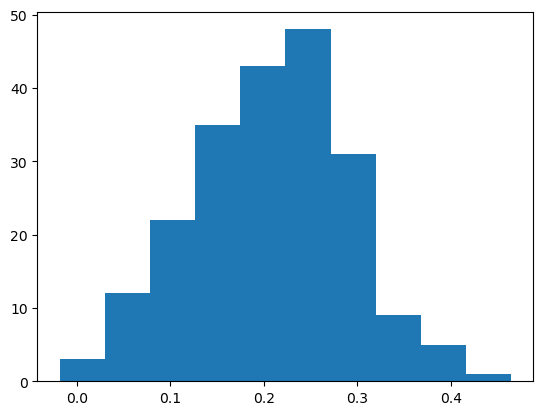

In [14]:
plt.hist(finalTable['Twitter_Weighted_Sentiment_Score'])

(array([ 3., 23., 63., 66., 31.,  9.,  7.,  1.,  1.,  5.]),
 array([0.04923586, 0.09281464, 0.13639343, 0.17997221, 0.223551  ,
        0.26712979, 0.31070857, 0.35428736, 0.39786614, 0.44144493,
        0.48502371]),
 <BarContainer object of 10 artists>)

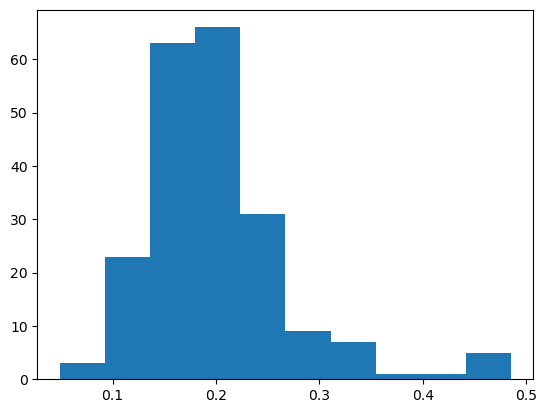

In [15]:
plt.hist(finalTable['Twitter_Sentiment_Score'])